<a href="https://colab.research.google.com/github/keropfia/Primary-models/blob/main/Model%20trial%20for%20fun%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.4 MB/s eta 0:00:00


In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm as tqdm

In [23]:
datafile_name = 'B. cereus growth data.xlsx'
data = pd.read_excel(datafile_name)
data

,Time (h),Rep 1,Rep 2,Rep 3
0,0,3.982365,3.827031,3.911132
1,4,3.846654,3.763745,3.932556
2,8,3.963752,3.930527,3.918763
3,12,3.520305,3.927485,3.788320
4,16,3.969261,3.861798,3.770790
5,20,3.930336,3.849437,3.980016
6,24,4.429522,4.523595,4.414396
7,28,4.277665,4.385004,4.305009
8,32,5.173528,5.226381,5.125501
9,36,5.016071,4.831717,4.909100


In [24]:
df = pd.read_excel("B. cereus growth data.xlsx")
t_data = df["Time (h)"].to_numpy()
y_data_mean = df[["Rep 1", "Rep 2", "Rep 3"]].mean(axis=1).to_numpy()
y_data_sd = df[["Rep 1", "Rep 2", "Rep 3"]].std(axis=1).to_numpy()

In [25]:
def baranyi_model(t, y0, ymax, mumax, lag):
    h0 = mumax * lag
    A = t + (1 / mumax) * np.log(np.exp(-mumax * t) + np.exp(-h0) - np.exp(-mumax * t - h0))
    return y0 + mumax * A - np.log(1 + (np.exp(mumax * A) - 1) / np.exp(ymax - y0))

In [26]:
model = Model(baranyi_model)
params = model.make_params(y0=min(y_data_mean), ymax=max(y_data_mean), mumax=0.5, lag=2.0)
params['y0'].set(min=0)
params['ymax'].set(min=0)
params['mumax'].set(min=0)
params['lag'].set(min=0)

result = model.fit(y_data_mean, params, t=t_data)

In [27]:
residuals = result.residual
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((y_data_mean - np.mean(y_data_mean)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

In [28]:
print(result.fit_report())
print(f"R²: {r_squared:.4f}")
for name, (val, low, high) in param_CI.items():
    print(f"  {name}: {val:.4f}  (95% CI: {low:.4f} – {high:.4f})")

[[Model]]
    Model(baranyi_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 16
    # variables        = 4
    chi-square         = 4.73495563
    reduced chi-square = 0.39457964
    Akaike info crit   = -11.4818618
    Bayesian info crit = -8.39150696
    R-squared          = 0.83126331
[[Variables]]
    y0:     4.20972542 +/- 0.20614027 (4.90%) (init = 3.74537)
    ymax:   6.83955549 +/- 0.29145162 (4.26%) (init = 7.645313)
    mumax:  4.41673797 +/- 1883068.31 (42634820.56%) (init = 0.5)
    lag:    39.6625099 +/- 141071.358 (355679.35%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(mumax, lag)  = +1.0000
    C(y0, lag)     = +0.2673
    C(y0, mumax)   = +0.2673
    C(ymax, mumax) = -0.2664
    C(ymax, lag)   = -0.2664
R²: 0.8313
  y0: 4.2097  (95% CI: 3.8057 – 4.6138)
  ymax: 6.8396  (95% CI: 6.2683 – 7.4108)
  mumax: 4.4167  (95% CI: -3690809.4645 – 3690818.2980)
  lag: 39.6625  (95% CI: -2764

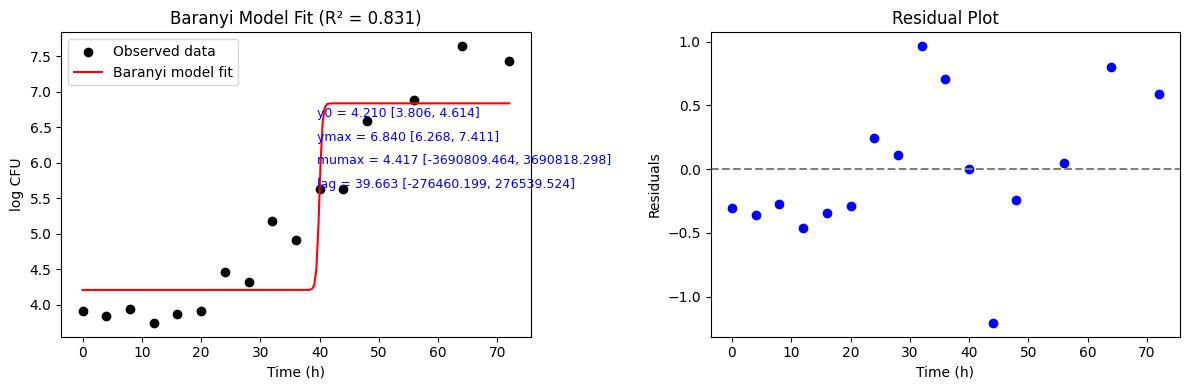

In [31]:
t_fit = np.linspace(0, max(t_data), 200)
y_fit = baranyi_model(t_fit, **result.best_values)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(t_data, y_data_mean, label='Observed data', color='black')
plt.plot(t_fit, y_fit, label='Baranyi model fit', color='red')
plt.xlabel('Time (h)')
plt.ylabel('log CFU')
plt.title(f'Baranyi Model Fit (R² = {r_squared:.3f})')
text_ypos = np.linspace(max(y_data_mean)-1, max(y_data_mean)-2, len(param_CI))
for i, (name, (val, low, high)) in enumerate(param_CI.items()):
    plt.text(max(t_data)*0.55, text_ypos[i],
             f"{name} = {val:.3f} [{low:.3f}, {high:.3f}]",
             fontsize=9, color='blue')
plt.legend()

plt.subplot(1, 2, 2)
plt.axhline(0, color='gray', linestyle='--')
plt.scatter(t_data, residuals, color='blue')
plt.xlabel('Time (h)')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()